# Real Hardware Fitting

In [5]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

## Expectation Value

## Two Qubit POVM with Trace

In [6]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    #for i, angle in enumerate(theta[2*n:3*n]):
    #    circuit.ry(angle, i)
        
    #for i, angle in enumerate(theta[3*n:]):
    #    circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [7]:
n = 2
d = 2**n
inputs, counts_list = pickle.load(open("../../data/twoQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)

In [8]:
targets = counts_to_probs(counts_list[:324])

In [13]:
n = 2
d = 2**n
rank = 8
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm_ideal(n),
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [14]:
model.train(inputs = inputs,
            targets = targets,
            inputs_val = inputs,
            targets_val = targets,
            num_iter = 500,
            N = 100
            )

  0%|          | 0/500 [00:00<?, ?it/s]

0 (0.042348407+8.223003e-10j)
1 (0.044516783+9.2116864e-10j)
2 (0.044405296+1.67614e-09j)
3 (0.0380075+1.9702464e-09j)
4 (0.040689208+1.0585495e-09j)
5 (0.035414137+1.3247408e-09j)
6 (0.03744796+1.5279552e-09j)
7 (0.0352821+8.158196e-10j)
8 (0.035816476+1.4439127e-09j)
9 (0.035997692+6.0785044e-10j)
10 (0.04097354-1.8655497e-10j)
11 (0.040590893+9.500757e-10j)
12 (0.03891373+6.645383e-10j)
13 (0.039652128+1.3814434e-09j)
14 (0.034452338+8.424731e-10j)
15 (0.030165082+4.492119e-11j)
16 (0.037515584+1.573781e-09j)
17 (0.029350376+5.1645445e-11j)
18 (0.03040678+1.0638108e-09j)
19 (0.03128043+1.4704606e-09j)
20 (0.032305375+9.818997e-10j)
21 (0.031413127+3.3482542e-10j)
22 (0.030628338+5.1438603e-10j)
23 (0.028274955+4.949904e-10j)
24 (0.03048364+1.0274872e-09j)
25 (0.027704725+1.040674e-09j)
26 (0.029012986+1.2300589e-09j)
27 (0.030835379-1.5861876e-10j)
28 (0.027296072+5.042733e-10j)
29 (0.029225213+1.08302894e-10j)
30 (0.02571626+1.9797049e-10j)
31 (0.027385924+1.1125598e-09j)
32 (0.027

254 (0.0001629461+1.9546077e-11j)
255 (0.00018307287+1.6268771e-11j)
256 (0.00018915586-6.8185735e-12j)
257 (0.00017814964+8.541763e-12j)
258 (0.00017138362+6.648144e-13j)
259 (0.00014860522+5.6325877e-12j)
260 (0.00018172045+2.9943537e-12j)
261 (0.00017214651-6.8130623e-12j)
262 (0.00017196621+2.8950902e-12j)
263 (0.00015644889+6.5658286e-13j)
264 (0.00014385706+6.6198436e-12j)
265 (0.00014529329-8.254498e-12j)
266 (0.00014041086+1.0903214e-11j)
267 (0.00016542096+2.4776045e-12j)
268 (0.0001377951+4.660833e-12j)
269 (0.00012191924+5.4301065e-12j)
270 (0.00014028071+1.677795e-11j)
271 (0.00016226638+1.6041547e-11j)
272 (0.00013970897+1.2210874e-11j)
273 (0.00013398289-5.619211e-12j)
274 (0.00013451056+1.0553598e-11j)
275 (0.000141176-1.254866e-11j)
276 (0.00013594843+1.06752185e-11j)
277 (0.00012407123+1.9371997e-11j)
278 (0.00013748695-6.14985e-12j)
279 (0.000118433934+6.648703e-12j)
280 (0.00012377878-3.6343283e-12j)
281 (0.00012982516-1.3227882e-12j)
282 (0.00012253317+1.3953296e-11

In [15]:
state_unitary = state_model = np.zeros((1, d,d))
state_unitary[0, 0, 0] = 1

state_unitary = tf.cast(state_unitary, dtype=tf.complex64)
state_model = tf.cast(state_model, dtype=tf.complex64)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex64)
model_expectation_list = []
unitary_expectation_list = []


probs = counts_to_probs(counts_list[324:-d**2])
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
#    state_unitary = U@state_unitary@U.T.conj()
#    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

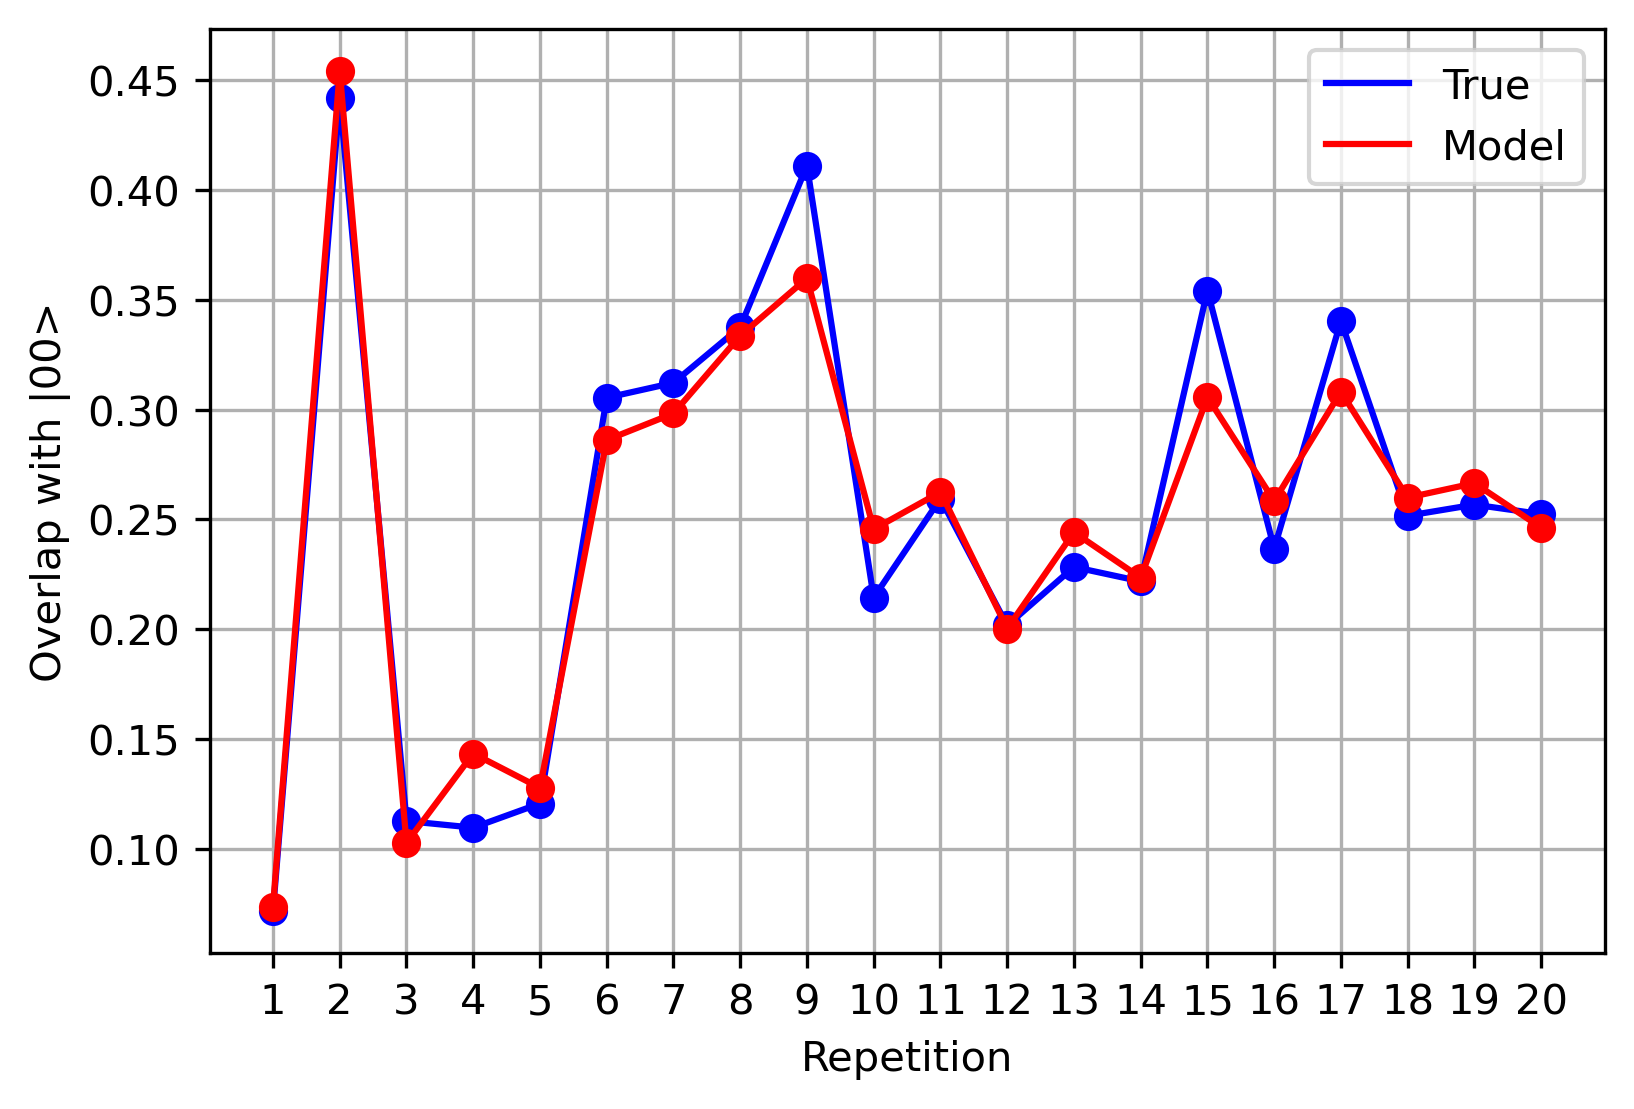

In [16]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

#plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
#plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Three Qubits 

In [35]:
n = 3
d = 2**n
inputs, counts_list = pickle.load(open("../../data/threeQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)

targets = counts_to_probs(counts_list[:5000])
rank = 64
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       povm = povm_ideal(n),
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [39]:
model.train(inputs = inputs,
            targets = targets,
            inputs_val = inputs,
            targets_val = targets,
            num_iter = 1000,
            N = 500
            )

  0%|          | 0/300 [00:00<?, ?it/s]

0 (2.5287927e-05-1.90928e-14j)
1 (2.3732475e-05-1.2176694e-13j)
2 (2.3354185e-05+3.164169e-12j)
3 (2.5948097e-05-9.173583e-13j)
4 (2.8393713e-05+2.5473551e-12j)
5 (2.3973555e-05-5.158551e-13j)
6 (2.532857e-05-2.5948915e-13j)
7 (2.4627745e-05+1.3805476e-12j)
8 (2.561396e-05+1.1126619e-12j)
9 (2.514487e-05+5.961209e-13j)
10 (2.2666005e-05+1.793647e-12j)
11 (2.3750537e-05+4.745246e-13j)
12 (2.4860658e-05+8.670314e-13j)
13 (2.6791557e-05+7.4583173e-13j)
14 (2.4179635e-05+1.5205484e-12j)
15 (2.4043396e-05+8.929241e-13j)
16 (2.4340283e-05+1.0450331e-12j)
17 (2.5204006e-05+1.8494043e-12j)
18 (2.2369875e-05+3.163436e-12j)
19 (2.5384705e-05+9.610082e-13j)
20 (2.3985724e-05+1.588526e-12j)
21 (2.2669365e-05+5.206525e-13j)
22 (2.5456115e-05+1.634838e-12j)
23 (2.1966905e-05+1.7435294e-12j)
24 (2.4020224e-05+1.9385552e-12j)
25 (2.4046714e-05-4.4557088e-13j)
26 (2.2900074e-05+2.1894812e-13j)
27 (2.0475394e-05+9.774366e-13j)
28 (2.1076377e-05+1.0925174e-12j)
29 (2.2823664e-05+5.575365e-13j)
30 (2.1864

246 (1.3358595e-05+1.8753605e-13j)
247 (1.3598348e-05-2.0562867e-13j)
248 (1.4004099e-05-1.9999124e-13j)
249 (1.4251755e-05-5.1859175e-14j)
250 (1.397222e-05-3.9538907e-13j)
251 (1.42560275e-05-9.093407e-14j)
252 (1.2818549e-05-2.5664887e-13j)
253 (1.3206463e-05+7.715596e-13j)
254 (1.23003665e-05+5.575335e-13j)
255 (1.3465179e-05-1.8462589e-13j)
256 (1.2658947e-05+6.1645724e-13j)
257 (1.3216528e-05+1.055612e-12j)
258 (1.3088442e-05+9.61063e-13j)
259 (1.3754275e-05-3.5500422e-13j)
260 (1.4577222e-05-1.149381e-12j)
261 (1.2811742e-05+1.2504373e-12j)
262 (1.4425106e-05+5.7761543e-13j)
263 (1.43420675e-05-2.6068264e-13j)
264 (1.3410043e-05+8.8776604e-13j)
265 (1.3380789e-05+3.1543927e-13j)
266 (1.3198081e-05+5.6101757e-14j)
267 (1.3100603e-05+1.2212358e-12j)
268 (1.2755939e-05-1.8254276e-12j)
269 (1.3841065e-05-1.4168018e-12j)
270 (1.3479801e-05-7.7902886e-13j)
271 (1.2719017e-05+1.196302e-12j)
272 (1.3477409e-05+1.7862281e-12j)
273 (1.2518147e-05+6.953262e-13j)
274 (1.374113e-05+8.03901e-

In [40]:
state_unitary = state_model = np.zeros((1, d,d))
state_unitary[0, 0, 0] = 1

state_unitary = tf.cast(state_unitary, dtype=tf.complex64)
state_model = tf.cast(state_model, dtype=tf.complex64)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex64)
model_expectation_list = []
unitary_expectation_list = []


probs = counts_to_probs(counts_list[5000:-d**2])
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.povm)
    model_expectation_list.append(expectation_value(probs, observ))

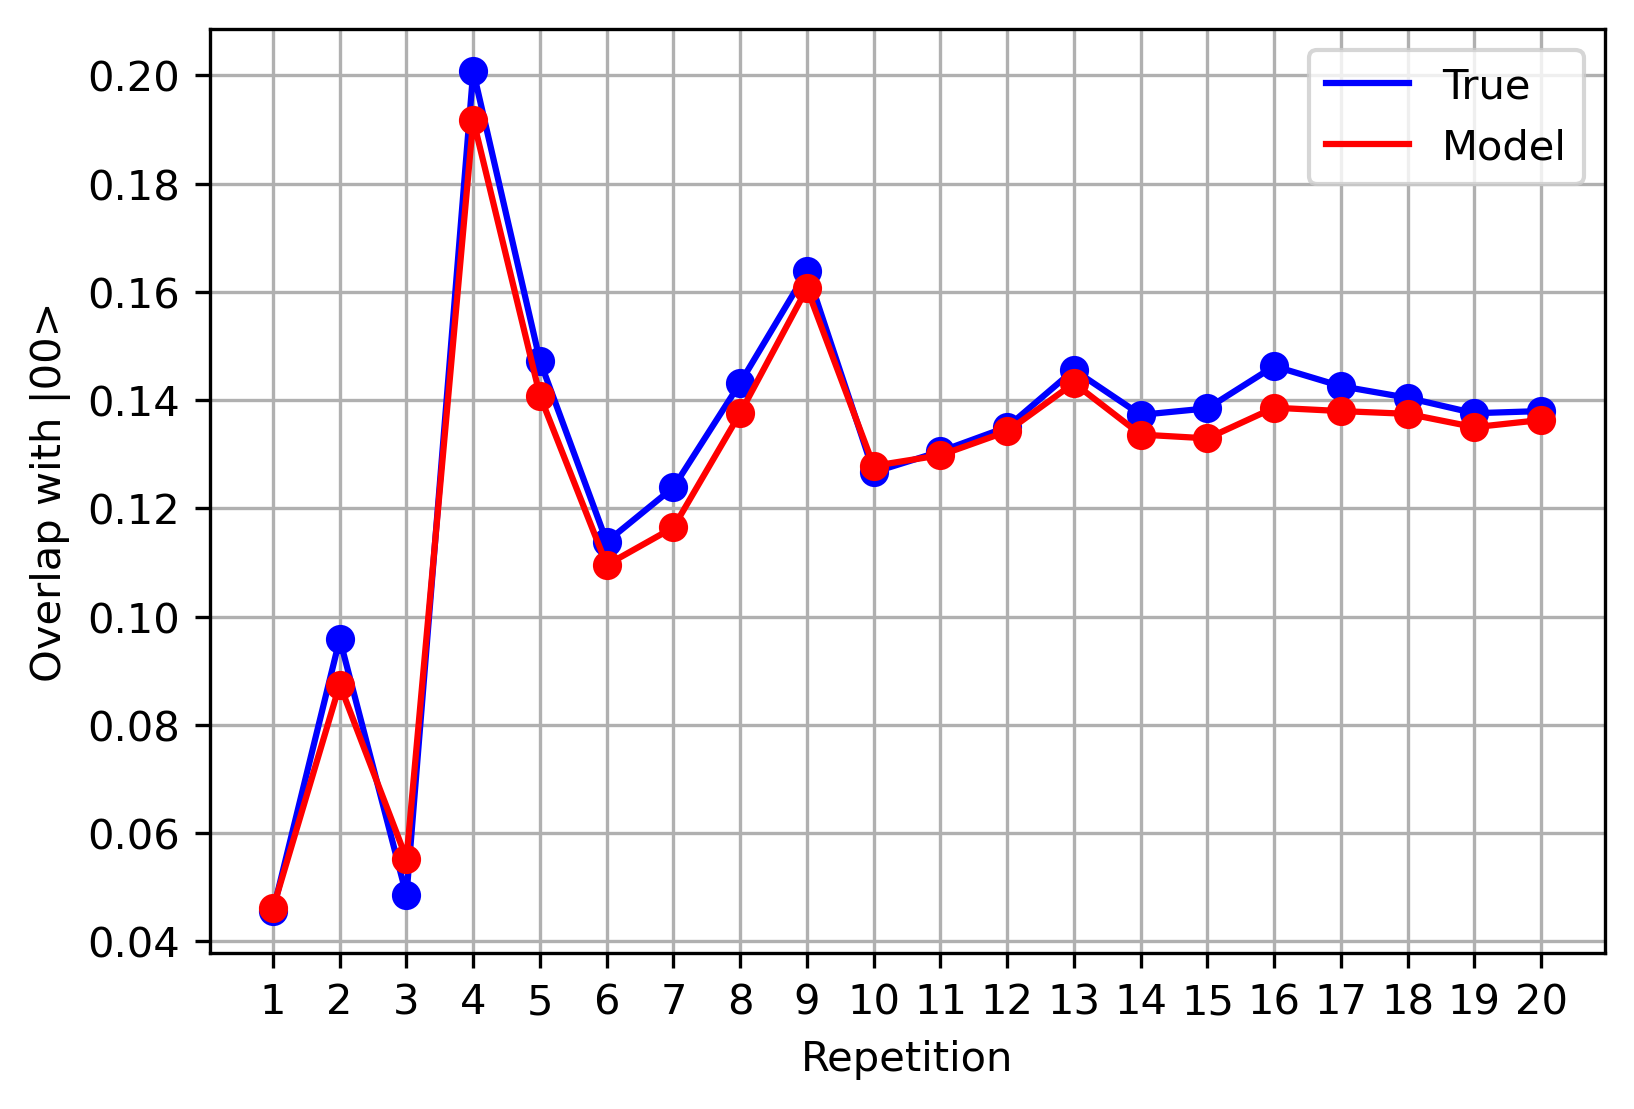

In [41]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

#plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
#plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Two Qubits, Two Blocks

In [ ]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_twoBlocks.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

In [ ]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train1, input_train2 = input_list[:324], input_list[324:]
target_train1, target_train2 = target_list[:324], target_list[324:]

In [ ]:
rank = 8
np.random.seed(42)
random.seed(42)

np.random.seed(42)
random.seed(42)

kraus_model1 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model1 = ModelQuantumMap(
                        q_map = kraus_model1,
                        loss = probs_loss,
                        input_list = input_train1,
                        target_list = target_train1,
                        input_val_list = input_train1,
                        target_val_list = target_train1,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

kraus_model2 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model2 = ModelQuantumMap(
                        q_map = kraus_model2,
                        loss = probs_loss,
                        input_list = input_train2,
                        target_list = target_train2,
                        input_val_list = input_train2,
                        target_val_list = target_train2,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [ ]:
model1.train(num_iter = 200,
             N = 50
            )

In [ ]:
model2.train(num_iter = 200,
             N = 50
            )

In [ ]:
state = np.zeros((d,d))
state[0,0] = 1
state = tf.cast(state, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)

state = model1.q_map.apply_map(state)
state = model2.q_map.apply_map(state)
probs_model = np.abs(measurement(state, povm = povm).numpy())

probs_true = counts_to_probs(counts_list[2*324])

print("Model:", probs_model)
print("True:", probs_true)

## Three Qubits, Two Blocks

In [ ]:
n = 3
d = 2**n
input_list, counts_list = pickle.load(open("../../data/threeQubits_twoBlocks.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

In [ ]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train1, input_train2 = input_list[:1000], input_list[1000:]
target_train1, target_train2 = target_list[:1000], target_list[1000:]

In [ ]:
rank = 16
np.random.seed(42)
random.seed(42)

np.random.seed(42)
random.seed(42)

kraus_model1 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model1 = ModelQuantumMap(
                        q_map = kraus_model1,
                        loss = probs_loss,
                        input_list = input_train1,
                        target_list = target_train1,
                        input_val_list = input_train1[:100],
                        target_val_list = target_train1[:100],
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

kraus_model2 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model2 = ModelQuantumMap(
                        q_map = kraus_model2,
                        loss = probs_loss,
                        input_list = input_train2,
                        target_list = target_train2,
                        input_val_list = input_train2[:100],
                        target_val_list = target_train2[:100],
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [ ]:
model1.train(num_iter = 200,
             N = 50
            )

In [ ]:
model2.train(num_iter = 200,
             N = 50
            )

In [ ]:
state = np.zeros((d,d))
state[0,0] = 1
state = tf.cast(state, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)

state = model1.q_map.apply_map(state)
state = model2.q_map.apply_map(state)
probs_model = np.abs(measurement(state, povm = povm).numpy())

probs_true = counts_to_probs(counts_list[2*1000])

print("Model:", probs_model)
print("True:", probs_true)

## Test

In [ ]:
np.random.seed(42)
A = tf.convert_to_tensor(np.random.normal(0,1,(1, 2, 4,4)))

B = tf.convert_to_tensor(np.random.normal(0,1,(5, 1, 4,4)))

In [ ]:
C = tf.matmul(A,B)
C = tf.matmul(C,A, adjoint_b=False)
C = tf.reduce_sum(C, axis=1)

In [ ]:
print(C)

In [ ]:
A = tf.convert_to_tensor(np.random.normal(0, 1, (4*2, 4)))

In [ ]:
print(A.reshape(2, 4, 4))

In [ ]:
print(tf.reshape(A, (2, 4, 4)))

In [ ]:
np.random.seed(42)
A = tf.convert_to_tensor(np.random.normal(0, 1, (1, 2, 4, 4)))
B = tf.convert_to_tensor(np.random.normal(0, 1, (5, 1, 4, 4)))
AB = tf.matmul(A, B)
print(AB.shape)

c = tf.linalg.trace(AB)
print(c.shape)